<a href="https://colab.research.google.com/github/mkap007/Machine_Learning_Codsoft/blob/main/Bank_Customer_Churn_Prediction_Task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Libraries**

In [38]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',None)
sns.set_style('darkgrid')

from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

**Importing Dataset**

In [39]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Churn_Modelling.csv")

In [40]:
df.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [42]:
df.describe().style.background_gradient(cmap='copper')

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.500000,15690940.569400,650.528800,38.921800,5.012800,76485.889288,1.530200,0.705500,0.515100,100090.239881,0.203700
std,2886.895680,71936.186123,96.653299,10.487806,2.892174,62397.405202,0.581654,0.455840,0.499797,57510.492818,0.402769
min,1.000000,15565701.000000,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,2500.750000,15628528.250000,584.000000,32.000000,3.000000,0.000000,1.000000,0.000000,0.000000,51002.110000,0.000000
50%,5000.500000,15690738.000000,652.000000,37.000000,5.000000,97198.540000,1.000000,1.000000,1.000000,100193.915000,0.000000
75%,7500.250000,15753233.750000,718.000000,44.000000,7.000000,127644.240000,2.000000,1.000000,1.000000,149388.247500,0.000000
max,10000.000000,15815690.000000,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


**Unique Values sorting**

In [43]:
def describe_(df):
    dict_=pd.DataFrame()
    dict_['null_values']=df.isna().sum()
    dict_['unique_']=df.nunique().values

    return dict_
describe_(df).style.background_gradient(cmap='copper_r')

,null_values,unique_
RowNumber,0,10000
CustomerId,0,10000
Surname,0,2932
CreditScore,0,460
Geography,0,3
Gender,0,2
Age,0,70
Tenure,0,11
Balance,0,6382
NumOfProducts,0,4


*Dataset contains about 10000 entries, with 14 different features. There aren't any null values in the data 'RowNumber' and 'CustomerId' feature would not be required for modeling or visualization therefore we will drop them*

In [44]:
df.drop(['RowNumber','CustomerId', 'Surname'],axis=1,inplace=True)

**EDA**

<Axes: xlabel='Exited', ylabel='count'>

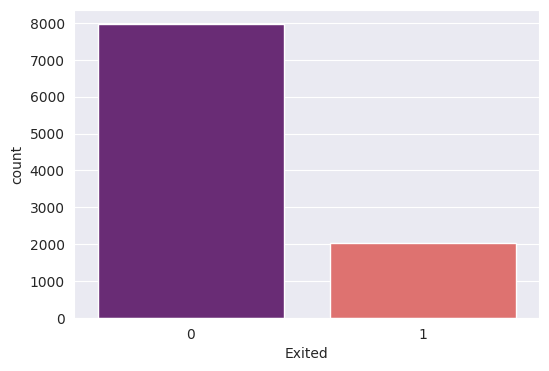

In [45]:
plt.figure(figsize=(6,4))
sns.countplot(x='Exited',data=df,palette='magma')

**Sampling for Imbalanced Datasets**

<Axes: xlabel='Gender', ylabel='count'>

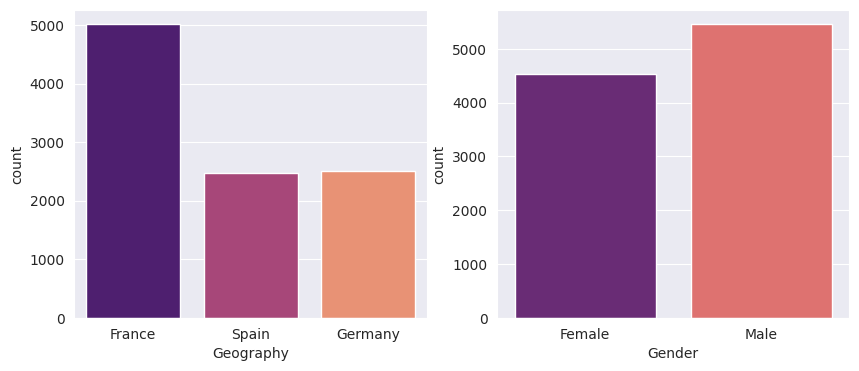

In [46]:
fig=plt.figure(figsize=(10,4))
ax=[None for _ in range(2)]
ax[0]=plt.subplot2grid((1,2),(0,0))
ax[1]=plt.subplot2grid((1,2),(0,1))

sns.countplot(x='Geography',data=df,palette='magma',ax=ax[0])
sns.countplot(x='Gender',data=df,palette='magma',ax=ax[1])

In [47]:
numerical_features=[feature for feature in df.columns if df[feature].dtype!='object']
df_num=df[numerical_features]

<Axes: >

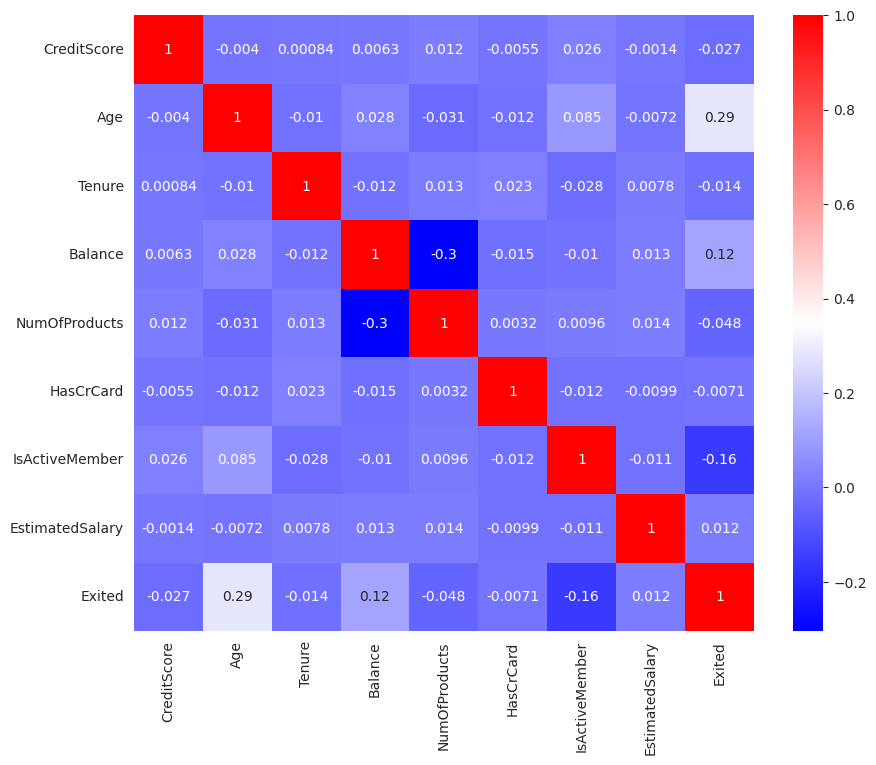

In [48]:
plt.figure(figsize=(10,8))
corr=df_num.corr()
sns.heatmap(corr,cmap=plt.cm.bwr,annot=True,annot_kws={'size':10})

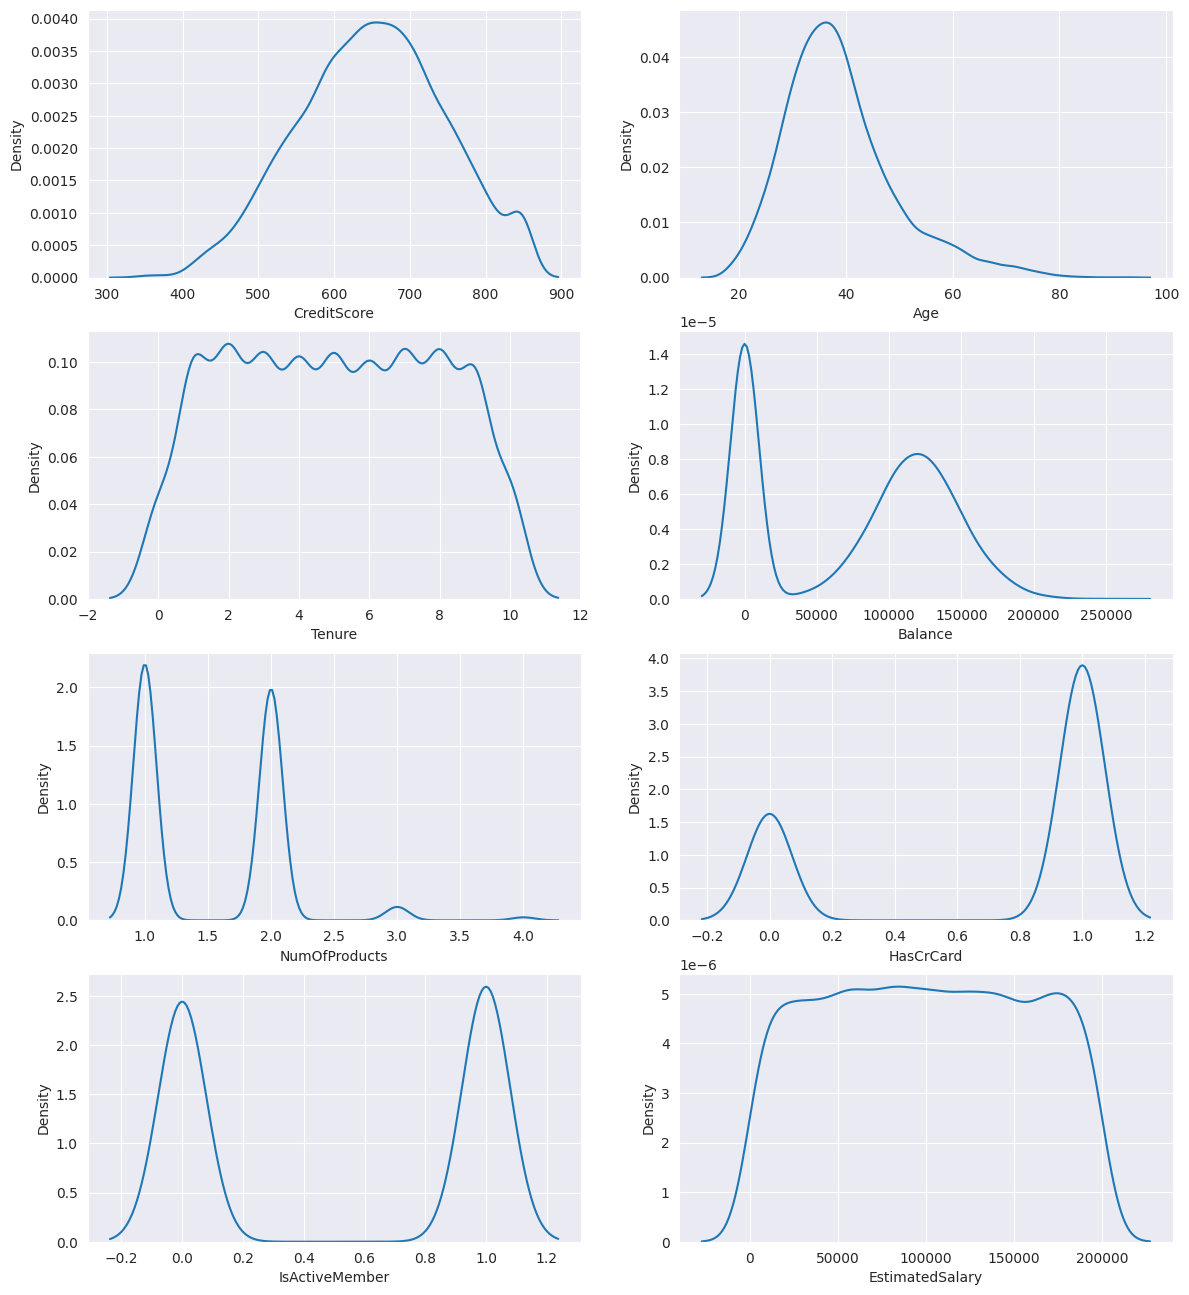

In [49]:
if 'Exited' in numerical_features:
    numerical_features.remove('Exited')

fig,ax=plt.subplots(nrows=4,ncols=2,figsize=(14,16))
i=0
for feature in numerical_features:
    n=i//2
    m=i%2
    sns.kdeplot(x=feature,data=df,ax=ax[n,m])
    i+=1

**Data Process**

In [51]:
df_num=df[numerical_features]
df_cat=df[['Geography','Gender']]

In [52]:
scaler=StandardScaler()
df_num=pd.DataFrame(scaler.fit_transform(df_num),columns=df_num.columns)

In [53]:
encoder=OneHotEncoder()
df_cat=pd.DataFrame(encoder.fit_transform(df_cat).toarray())
df_cat.columns=df_cat.columns.astype(str)

In [54]:
df_=pd.concat([df_num,df_cat],axis=1)

In [55]:
y=df['Exited']

**Model Training**<br>
**1. Random Forest**

In [56]:
forest=RandomForestClassifier()
param_grid = {
    'n_estimators': [100,200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
grid_search=RandomizedSearchCV(estimator=forest,param_distributions=param_grid,cv=3,scoring='roc_auc',n_iter=10,verbose=True)

In [57]:
grid_search.fit(df_,y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [4, 5, 6, 7, 8],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [100, 200, 500]},
                   scoring='roc_auc', verbose=True)

In [58]:
forest=grid_search.best_estimator_
scores_forest=cross_val_score(forest,df_,y,cv=5)
print('Mean value of ROC for RF Classifier:{}'.format(np.mean(scores_forest)))

Mean value of ROC for RF Classifier:0.8606999999999999


**2. Decision Tree**

In [59]:
tree=DecisionTreeClassifier()
param_grid={
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}
grid_search=RandomizedSearchCV(estimator=tree,param_distributions=param_grid,cv=5,scoring='roc_auc',n_iter=10,verbose=True)

In [60]:
grid_search.fit(df_,y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 3, 5, 10, 20],
                                        'min_samples_leaf': [5, 10, 20, 50,
                                                             100]},
                   scoring='roc_auc', verbose=True)

In [61]:
tree=grid_search.best_estimator_
scores_tree=cross_val_score(tree,df_,y,cv=5)
print('Mean value of ROC for Dt Classifier:{}'.format(np.mean(scores_tree)))

Mean value of ROC for Dt Classifier:0.8525


**3. XGB**

In [62]:
xgb=XGBClassifier()
param_grid={
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
grid_search=RandomizedSearchCV(estimator=xgb,param_distributions=param_grid,cv=3,scoring='roc_auc',n_iter=10,verbose=True)

In [63]:
grid_search.fit(df_,y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'max_depth': [3, 4, 5],
                                        'min_child_weight': [1, 5, 10],
                                        'subsample': [0.6, 0.8, 1.0]},
                   scoring='roc_auc', verbose=True)

In [64]:
xgb=grid_search.best_estimator_
scores_xgb=cross_val_score(xgb,df_,y,cv=5)
print('Mean value of ROC for XGB Classifier:{}'.format(np.mean(scores_xgb)))

Mean value of ROC for XGB Classifier:0.8625


**4. LGBM**

In [65]:
lgbm=LGBMClassifier(objective = 'binary',
                     n_estimators = 500,
                     max_depth = 7,
                     learning_rate = 0.01,
                     num_leaves = 20,
                     reg_alpha = 3,
                     reg_lambda = 3,
                     subsample = 0.7,
                     colsample_bytree = 0.7)
lgbm_scores=cross_val_score(lgbm,df_,y,cv=3)
np.mean(lgbm_scores)

[LightGBM] [Info] Number of positive: 1358, number of negative: 5308
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 863
[LightGBM] [Info] Number of data points in the train set: 6666, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203720 -> initscore=-1.363202
[LightGBM] [Info] Start training from score -1.363202
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1358, number of negative: 5309
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001079 seconds.
You can set `force_col_wise=true` to remove the 

0.8618995372842623

**Voting Result**

In [66]:
voting_clf = VotingClassifier(
 estimators=[('xgb', xgb), ('rf', forest),('tree',tree),('lgbm',lgbm)],
 voting='soft'
 )
scores_voting=cross_val_score(voting_clf,df_,y,cv=5)
print('Mean value of ROC-AUC Score for Voting classifier:{}'.format(np.mean(scores_voting)))

[LightGBM] [Info] Number of positive: 1629, number of negative: 6371
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203625 -> initscore=-1.363790
[LightGBM] [Info] Start training from score -1.363790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1629, number of negative: 6371
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 862
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203625 -> initscore=-1.363790